In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Business Objective

Membangun model prediksi churn pelanggan yang andal dengan menggunakan teknik Hyperparameter Tuning (cross-validation) dengan memilih metrik pemodelan yang tepat. Dengan tujuan akhir, yaitu interpretasikan hasil evaluasi untuk memahami bagaimana model dapat dioptimalkan lebih lanjut.

## Data Understanding

In [ ]:
# load datasets
df = pd.read_csv('/content/churn.csv')

In [ ]:
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


In [ ]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['customerID', 'Gender', 'Partner', 'Dependents', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [ ]:
for column in categorical_cols:
  print(f"======= {column} =======")
  display(df[column].value_counts())
  print()

======= customerID =======


,count
customerID,
3604-WLABM,2
5067-WJEUN,2
2342-CKIAO,2
5233-GEEAX,2
2905-KFQUV,2
...,...
2637-FKFSY,1
1552-AAGRX,1
4304-TSPVK,1



======= Gender =======


,count
Gender,
Male,3552
Female,3478



======= Partner =======


,count
Partner,
No,3638
Yes,3392



======= Dependents =======


,count
Dependents,
No,4931
Yes,2096



======= Contract =======


,count
Contract,
Month-to-month,3873
Two year,1689
One year,1471



======= PaperlessBilling =======


,count
PaperlessBilling,
Yes,4168
No,2865



======= PaymentMethod =======


,count
PaymentMethod,
Electronic check,2367
Mailed check,1604
Bank transfer (automatic),1540
Credit card (automatic),1524



======= Churn =======


,count
Churn,
No,5174
Yes,1872


📑 Data Dictionary
| Kolom            | Deskripsi                                                                      |
| ---------------- | ------------------------------------------------------------------------------ |
| customerID       | ID unik pelanggan                                                              |
| Gender           | Jenis kelamin pelanggan (Male/Female)                                          |
| SeniorCitizen    | Status pelanggan senior (0 = Tidak, 1 = Ya)                                    |
| Partner          | Apakah pelanggan memiliki pasangan (Yes/No)                                    |
| Dependents       | Apakah pelanggan memiliki tanggungan (Yes/No)                                  |
| Tenure           | Lama pelanggan berlangganan (dalam bulan)                                      |
| Contract         | Jenis kontrak (Month-to-month, One year, Two year)                             |
| PaperlessBilling | Status tagihan online (Yes/No)                                                 |
| PaymentMethod    | Metode pembayaran (Electronic check, Mailed check, Bank transfer, Credit card) |
| MonthlyCharges   | Biaya bulanan yang dibayarkan pelanggan                                        |
| TotalCharges     | Total biaya yang sudah dibayarkan pelanggan                                    |
| Churn            | Target: Apakah pelanggan churn (Yes/No)                                        |


🔎 Observasi:
- Terdapat 7046 data dengan 12 kolom, dengan target (Y) analisis pada kolom `Churn (Yes/No)`.
- Hampir semua kolom (variabel) terdeteksi missing value, kecuali kolom `TotalCharges` dan `Churn`
- Untuk analisis prediksi, kolom `customerID` dapat di drop karena tidak mendefinisikan apapun
- Variabel kategorikal -> metode encoding:
  - label encoding: `'Gender'`, `'Partner'`, `'Dependents'`, `'PaperlessBilling'`, `'Churn'`
  - ordinal encoding: `'Contract'`
  - One hot (>2 kategori): `'PaymentMethod'`

# Data Preparation

## Data Cleaning

### Duplicate

In [ ]:
df.duplicated().sum()

np.int64(14)

In [ ]:
df[df.duplicated()]

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7032,2905-KFQUV,Female,0.0,Yes,No,2.0,Month-to-month,Yes,Credit card (automatic),70.40,154.80,No
7033,9253-QXKBE,Male,1.0,Yes,No,29.0,Month-to-month,Yes,Electronic check,94.45,2653.65,Yes
7034,6418-HNFED,Male,0.0,Yes,No,51.0,Two year,Yes,Credit card (automatic),83.25,4089.45,No
7035,4795-UXVCJ,Male,0.0,No,No,26.0,One year,No,Credit card (automatic),19.80,457.30,No
7036,3606-SBKRY,Male,0.0,No,No,31.0,One year,Yes,Electronic check,50.05,1523.40,No
7037,5233-GEEAX,Male,1.0,No,No,8.0,Month-to-month,Yes,Electronic check,29.40,221.90,Yes
7038,6000-UKLWI,Male,0.0,No,No,41.0,Two year,No,Mailed check,20.15,802.35,No
7039,2236-HILPA,Male,0.0,Yes,Yes,62.0,Two year,No,Credit card (automatic),20.65,1218.45,No
7040,2342-CKIAO,Female,0.0,No,No,2.0,Month-to-month,No,Mailed check,20.30,41.20,No
7041,5067-WJEUN,NaN,0.0,Yes,Yes,67.0,Two year,Yes,Bank transfer (automatic),54.20,3838.20,No


In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Missing Value

In [ ]:
df.drop('customerID', axis=1, inplace=True)

In [ ]:
df.isnull().sum()

,0
Gender,15
SeniorCitizen,12
Partner,16
Dependents,19
Tenure,17
Contract,13
PaperlessBilling,13
PaymentMethod,11
MonthlyCharges,10
TotalCharges,0


In [ ]:
df[df.isna().any(axis=1)]

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
26,Male,0.0,Yes,Yes,47.0,Month-to-month,NaN,Electronic check,99.35,4749.15,Yes
116,Female,0.0,No,No,NaN,Two year,No,Bank transfer (automatic),31.05,1126.35,No
122,Male,0.0,No,No,3.0,NaN,Yes,Electronic check,74.40,229.55,Yes
213,Female,NaN,Yes,Yes,29.0,One year,No,Electronic check,20.00,540.05,No
...,...,...,...,...,...,...,...,...,...,...,...
6726,Male,0.0,Yes,NaN,67.0,Two year,Yes,Mailed check,20.80,1411.90,No
6753,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,69.20,69.20,Yes
6821,Female,0.0,Yes,Yes,53.0,Two year,No,Mailed check,NaN,1146.05,No
6896,Female,0.0,No,No,41.0,Month-to-month,NaN,Bank transfer (automatic),70.25,2868.05,Yes


In [ ]:
# persentase missing value per kolom
# looping ini 100 * len(df[df['Gender'].isna()]) / len(df)
100 * len(df[df['Gender'].isna()]) / len(df)

missing_percentage = df.isnull().mean() * 100
print(missing_percentage)

Gender              0.213311
SeniorCitizen       0.170648
Partner             0.227531
Dependents          0.270193
Tenure              0.241752
Contract            0.184869
PaperlessBilling    0.184869
PaymentMethod       0.156428
MonthlyCharges      0.142207
TotalCharges        0.000000
Churn               0.000000
dtype: float64


#### Handling Missing Value

- numerik -> median
- categorik -> modus

In [ ]:
df['SeniorCitizen'].value_counts()

,count
SeniorCitizen,
0.0,5881
1.0,1139


In [ ]:
num_cols = df.select_dtypes(exclude='object').columns
num_cols = num_cols.drop('TotalCharges')
num_cols

Index(['SeniorCitizen', 'Tenure', 'MonthlyCharges'], dtype='object')

In [ ]:
df['SeniorCitizen'].mode()

,SeniorCitizen
0,0.0


In [ ]:
# median masing-masing num_cols
median_cols = df[num_cols].median()
print(f"Median kolom:\n{median_cols}")
df[num_cols] = df[num_cols].fillna(median_cols)

Median kolom:
SeniorCitizen      0.00
Tenure            29.00
MonthlyCharges    70.35
dtype: float64


In [ ]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols = cat_cols.drop('Churn')
cat_cols

Index(['Gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],
      dtype='object')

In [ ]:
mode_cols = df[cat_cols].mode().iloc[0]
print(f"Modus kolom:\n{mode_cols}")

Modus kolom:
Gender                          Male
Partner                           No
Dependents                        No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
Name: 0, dtype: object


In [ ]:
# handling cat_cols
mode_cols = df[cat_cols].mode().iloc[0]
print(f"Modus kolom:\n{mode_cols}")
df[cat_cols] = df[cat_cols].fillna(mode_cols)

Modus kolom:
Gender                          Male
Partner                           No
Dependents                        No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
Name: 0, dtype: object


In [ ]:
df.isnull().sum()

,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
Contract,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,0


## EDA

Identifikasi aspek penting seperti jumlah fitur, tipe data, serta distribusi target.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7031
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   float64
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   Tenure            7032 non-null   float64
 5   Contract          7032 non-null   object 
 6   PaperlessBilling  7032 non-null   object 
 7   PaymentMethod     7032 non-null   object 
 8   MonthlyCharges    7032 non-null   float64
 9   TotalCharges      7032 non-null   float64
 10  Churn             7032 non-null   object 
dtypes: float64(4), object(7)
memory usage: 659.2+ KB


In [ ]:
# fitur variabel
X = df.drop(['Churn'],axis=1)

#target variabel
y = df['Churn']

print(X.columns)
print(y.name)

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')
Churn


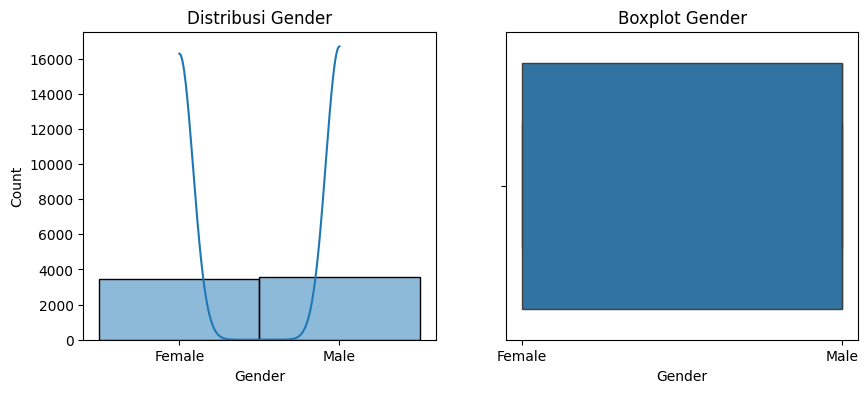

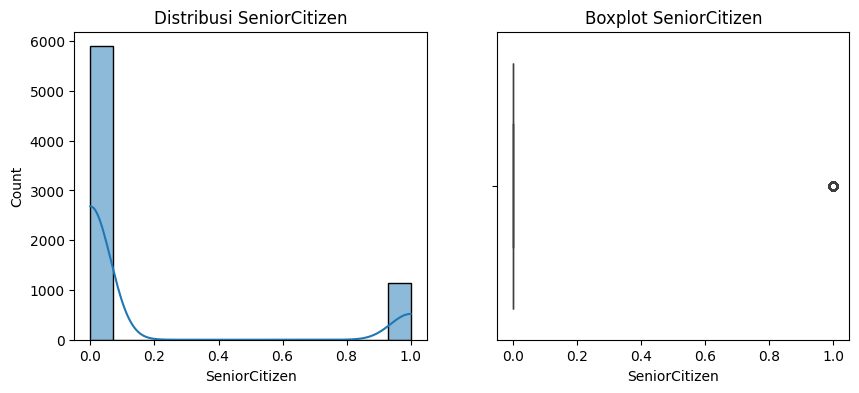

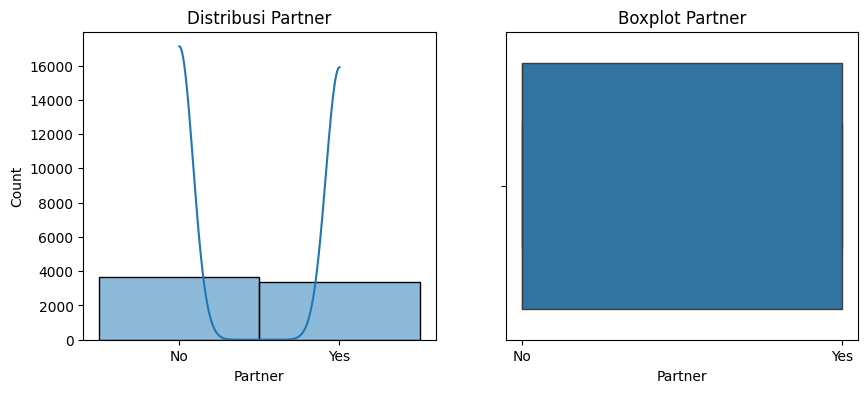

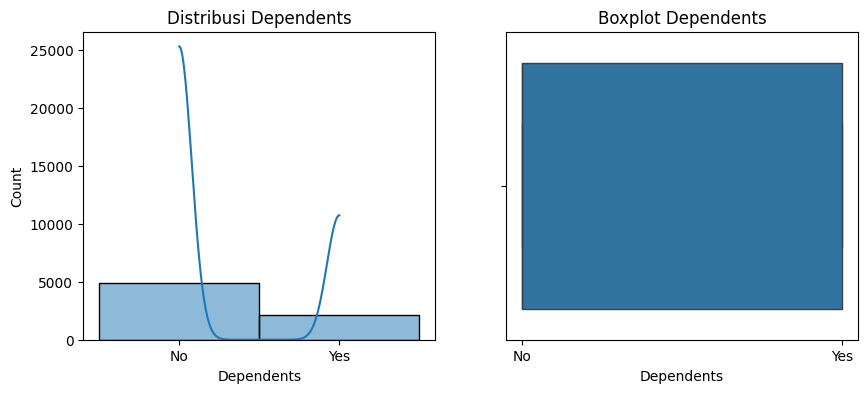

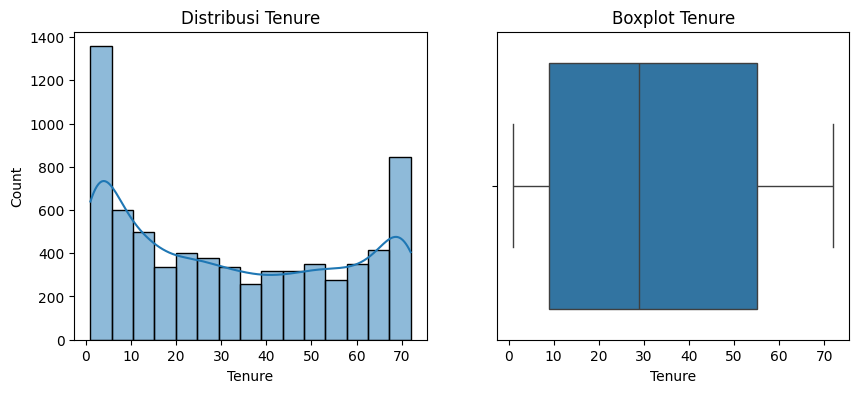

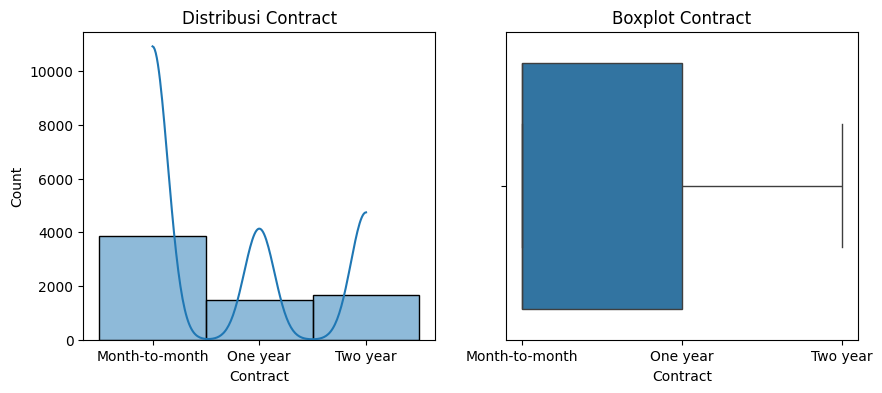

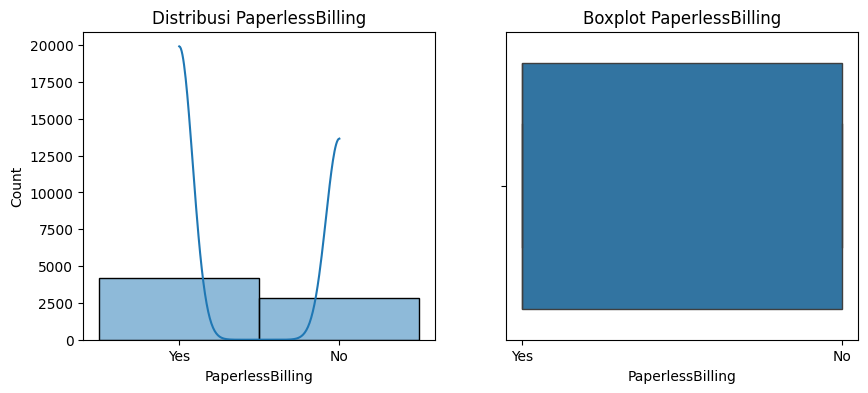

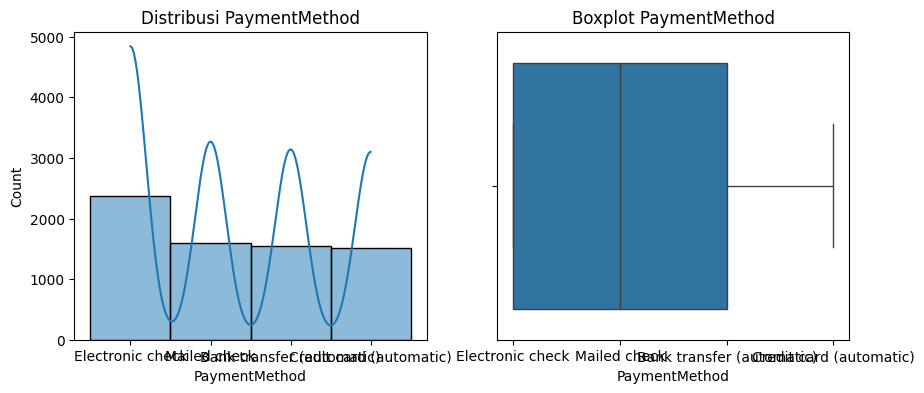

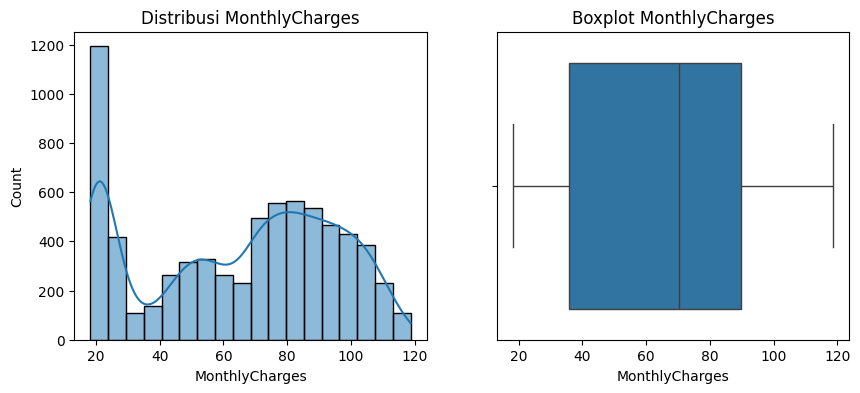

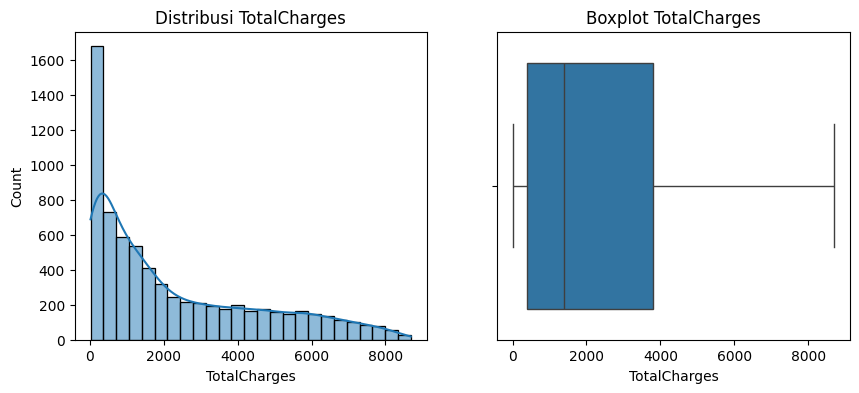

In [ ]:
# Distribusi (X)

import matplotlib.pyplot as plt
import seaborn as sns

for col in X.columns:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribusi {col}")

    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot {col}")

    plt.show()

In [ ]:
num_cols = X.select_dtypes(exclude='object').columns

num_summary = pd.DataFrame({
    "min": df[num_cols].min(),
    "max": df[num_cols].max(),
    "mean": df[num_cols].mean(),
    "std": df[num_cols].std(),
    "skewness": df[num_cols].skew()
})

print(num_summary)

                  min      max         mean          std  skewness
SeniorCitizen    0.00     1.00     0.161974     0.368453  1.835362
Tenure           1.00    72.00    32.409983    24.523179  0.239475
MonthlyCharges  18.25   118.75    64.830703    30.052773 -0.224641
TotalCharges    18.80  8684.80  2283.300441  2266.771362  0.961642


In [ ]:
# Distribusi Target
df['Churn'].value_counts()

,count
Churn,
No,5163
Yes,1869


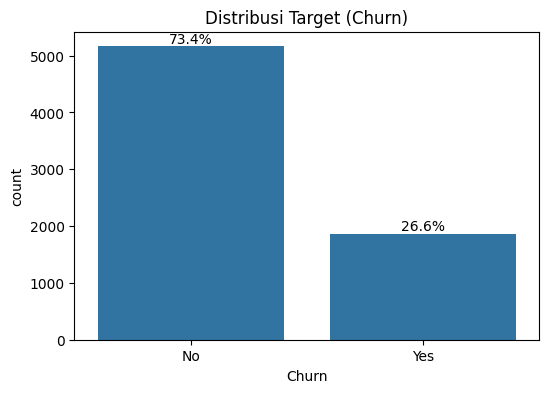

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Churn', data=df)
plt.title("Distribusi Target (Churn)")

# presentase
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / len(df)
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom')

plt.show()

🔎 Observasi:
- Terdapat 11 variabel yang di antaranya 10 fitur (variabel X) dan 1 target berupa object Yes/No (variabel Y), dengan tipe data float64(4), object(7)
- Variabel objek perlu di encoding untuk analisis Machine Learning dan perlu scaling pada variabel numerik untuk menyamakan skala data
- Distribusi variabel fitur pada variabel kategorik ada yang sedikit skewness ke kanan dan untuk variabel numerik varibel `'SeniorCitizen'` cukup condong pada 0 (tidak) dan `'TotalCharges'` cukup skew ke kanan
- Distribusi target terindikasi `Imbalanced`

# Encoding

Label Encoding untuk binary category.

One-hot encoding untuk kategori dengan lebih dari 2 class.

- label encoding: `'Gender'`, `'Partner'`, `'Dependents'`, `'PaperlessBilling'`, `'Churn'`
- ordinal encoding: `'Contract'`
- One hot (>2 kategori): `'PaymentMethod'`

## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

binary_cols = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']

label_encoder = LabelEncoder()

for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [ ]:
df[binary_cols].head()

,Gender,Partner,Dependents,PaperlessBilling,Churn
0,0,0,0,1,0
1,1,0,0,0,0
2,1,0,0,1,1
3,1,0,0,0,0
4,0,0,0,1,1


## Ordinal Encoding

In [ ]:
contract_mapping = {
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
}

df['Contract'] = df['Contract'].map(contract_mapping)

In [ ]:
df['Contract'].value_counts()

,count
Contract,
0,3879
2,1684
1,1469


## One Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['PaymentMethod'], prefix=['PaymentMethod'])

In [ ]:
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.0,0,0,1.0,0,1,29.85,29.85,0,False,False,True,False
1,1,0.0,0,0,34.0,1,0,56.95,1889.50,0,False,False,False,True
2,1,0.0,0,0,2.0,0,1,53.85,108.15,1,False,False,False,True
3,1,0.0,0,0,45.0,1,0,42.30,1840.75,0,True,False,False,False
4,0,0.0,0,0,2.0,0,1,70.70,151.65,1,False,False,True,False


# Feature Selection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7031
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Gender                                   7032 non-null   int64  
 1   SeniorCitizen                            7032 non-null   float64
 2   Partner                                  7032 non-null   int64  
 3   Dependents                               7032 non-null   int64  
 4   Tenure                                   7032 non-null   float64
 5   Contract                                 7032 non-null   int64  
 6   PaperlessBilling                         7032 non-null   int64  
 7   MonthlyCharges                           7032 non-null   float64
 8   TotalCharges                             7032 non-null   float64
 9   Churn                                    7032 non-null   int64  
 10  PaymentMethod_Bank transfer (automatic)  7032 non-nul

## Correlation Analysis

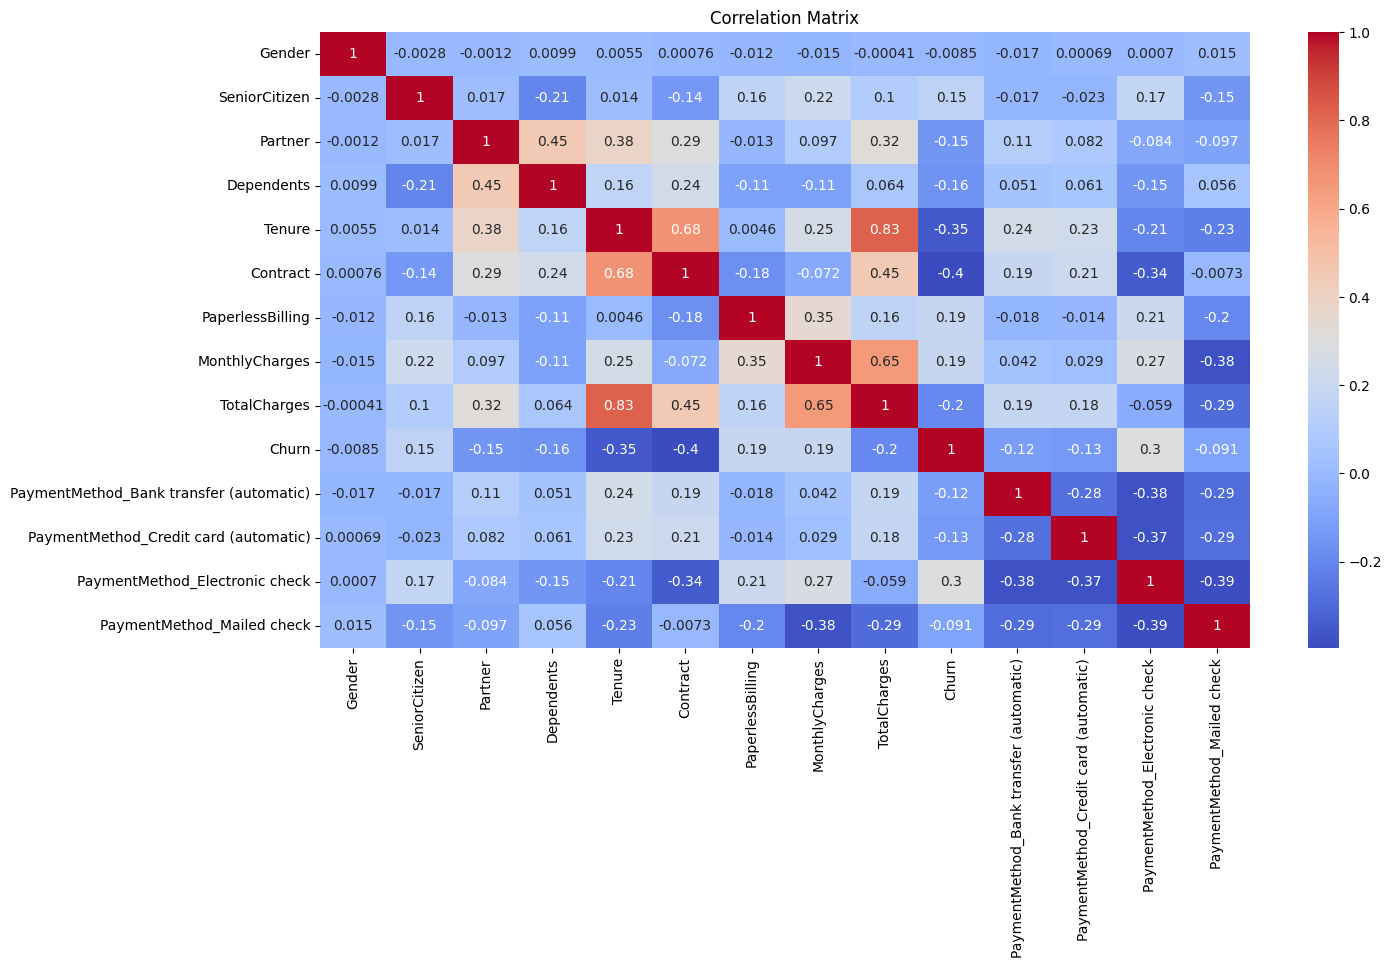

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Korelasi antar variabel X (tanpa target)
corr_matrix = df.drop(columns=['Churn']).corr()

# Tampilin variabel yang korelasi di atas 0.8
threshold = 0.8
high_corr = np.where((abs(corr_matrix) > threshold) & (abs(corr_matrix) < 1))

pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
         for x, y in zip(*high_corr)]

for p in pairs:
    print(p)

('Tenure', 'TotalCharges', np.float64(0.8254936245088063))
('TotalCharges', 'Tenure', np.float64(0.8254936245088063))


In [ ]:
# Feature Selection
 # Hilangkan fitur yang redundant (korelasi > 0.8), yaitu salah satu antara 'Tenure', 'TotalCharges', np.float64(0.8254936245088063))
df.drop(['TotalCharges'], axis=1, inplace=True)

📌 `TotalCharges (total biaya yang dibayarkan)` yang di drop karena biasanya merupakan hasil dari perkalian **'Tenure - MonthlyCharges'**, sehingga secara sistematis redundant.

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (5625, 12), Test shape: (1407, 12)


# Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scal_cols = ['MonthlyCharges', 'Tenure']

X_train[scal_cols] = scaler.fit_transform(X_train[scal_cols])
X_test[scal_cols] = scaler.transform(X_test[scal_cols])

# Modeling

Choose Evaluation Metrix

Jelaskan alasan pemilihan metrik tertentu dan bagaimana metrik tersebut digunakan untuk menilai kinerja model.

📝 Note Interpretasi Metric + Bandingkan Model
1. Precision = kualitas positif (berapa yang benar dari prediksi positif)
2. Recall = kuantitas positif (berapa banyak positif yang berhasil ditangkap).
3. F1 = keseimbangan precision & recall.
4. Accuracy = keseluruhan kebenaran (hati-hati kalau data imbalance).
5. AUC = seberapa pintar model membedakan kelas.

| **Metric**               | **Formula**                                     | **Fokus / Pertanyaan**                                               | **Interpretasi**                                                                                   |
| ------------------------ | ----------------------------------------------- | -------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------- |
| **Accuracy**             | (TP + TN) / (TP + TN + FP + FN)                 | Seberapa banyak prediksi benar dari semua data?                      | Bagus kalau data **seimbang**. Tidak cocok untuk data imbalance.                                   |
| **Precision**            | TP / (TP + FP)                                  | Dari semua prediksi positif, berapa yang benar-benar positif? -> perbandingan TP dengan banyaknya data yang **dipresiksi positif**       | Fokus pada **minimalkan false positive**. Penting di kasus seperti **email spam filter**.          |
| **Recall (Sensitivity)** | TP / (TP + FN)                                  | Dari semua positif sebenarnya, berapa yang berhasil ditangkap model? -> perbandingan TP dengan data yang **sebenarnya positif** | Fokus pada **minimalkan false negative**. Penting di kasus **kanker detection / fraud detection**. |
| **F1 Score**             | 2 × (Precision × Recall) / (Precision + Recall) | Seimbangkah Precision & Recall?                                      | Cocok saat data imbalance & butuh keseimbangan keduanya.                                           |
| **AUC (ROC-AUC)**        | Area under ROC curve (TPR vs FPR)               | Seberapa baik model membedakan kelas positif vs negatif?             | Nilai mendekati 1 = sangat baik, 0.5 = random. Cocok untuk **imbalance dataset**.                  |


📌 Insight:

Demikian, dalam kasus dataset ini yang terindikasi `imbalanced data` dan fokus analisis pada `deteksi churn` guna menghindari kerugian **(meminimalisir flase negative)** -> F1-score & Recall
- Recall tinggi -> lebih banyak pelanggan yang bisa “diselamatkan” lewat campaign (walaupun ada kemungkinan false positive alias campaign dikirim ke pelanggan yang sebenarnya nggak churn).
> Lebih baik mencegah dari pada kita tidak melakukan apa-apa

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

## Train Model & Hyperparameter Tuning

1. Pilih model machine learning yang sesuai dengan dataset.
2. Lakukan eksperimen dengan berbagai kombinasi hyperparameter.
3. Gunakan teknik validasi untuk membandingkan performa model dengan berbagai konfigurasi.

## Logistic Regression

In [ ]:
# Define
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

### Hyperparameter Tunning

In [ ]:
# Hyperparameter grid
param_grid_lr = {
    "C": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}

# GridSearchCV
grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    scoring="recall",               # note: we use recall
    cv=5,
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='recall')

In [ ]:
# the compact results
cv_results_lr = pd.DataFrame(grid_lr.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_results_lr = cv_results_lr[retain_cols].sort_values(by='rank_test_score')
cv_results_lr

,params,mean_test_score,rank_test_score
3,"{'C': 1e-05, 'solver': 'lbfgs'}",0.844147,1
5,"{'C': 0.0001, 'solver': 'lbfgs'}",0.842140,2
4,"{'C': 0.0001, 'solver': 'liblinear'}",0.834114,3
6,"{'C': 0.001, 'solver': 'liblinear'}",0.832107,4
7,"{'C': 0.001, 'solver': 'lbfgs'}",0.831438,5
2,"{'C': 1e-05, 'solver': 'liblinear'}",0.830769,6
0,"{'C': 1e-06, 'solver': 'liblinear'}",0.830100,7
1,"{'C': 1e-06, 'solver': 'lbfgs'}",0.830100,7
8,"{'C': 0.01, 'solver': 'liblinear'}",0.808027,9
9,"{'C': 0.01, 'solver': 'lbfgs'}",0.804682,10


In [ ]:
# the best model
log_reg_best_estimator = grid_lr.best_estimator_
log_reg_best_estimator

LogisticRegression(C=1e-05, class_weight='balanced', max_iter=1000,
                   random_state=42)

### Validation (CV)

In [ ]:
# definisikan model pakai best hyperparameter
log_reg_best_estimator = LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    log_reg_best_estimator.fit(X_train_, y_train_) # balanced and tuned model
    y_pred = log_reg_best_estimator.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("Logistic Regression (Best Hyperparameter)")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

Logistic Regression (Best Hyperparameter)
Accuracy mean: 0.7394753523583061 std: 0.010995041946753369
Precision mean: 0.5062909075301223 std: 0.012888159473337464
Recall mean: 0.7891767913804342 std: 0.01295424212261765
F1 mean: 0.6167658837820065 std: 0.011878025688214956


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    log_reg.fit(X_train_, y_train_) # baseline
    y_pred = log_reg.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("Logistic Regression Baseline Model")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

Logistic Regression Baseline Model
Accuracy mean: 0.7384806307822804 std: 0.010967206727090319
Precision mean: 0.5050350678545892 std: 0.01574548591763202
Recall mean: 0.8011529579430446 std: 0.011531269737049994
F1 mean: 0.6194011528198918 std: 0.013477712237576642


## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced") # -> balanced

### Hyperparameter Tunning

In [ ]:
# Hyperparameter grid
param_grid_dt = {
    'max_depth': [None, 3, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]}

# GridSearchCV
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring="recall",               # note: we use recall
    cv=5,
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10, 20, 30, 50],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [ ]:
# the compact results
cv_results_dt = pd.DataFrame(grid_dt.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_results_dt = cv_results_dt[retain_cols].sort_values(by='rank_test_score')
cv_results_dt

,params,mean_test_score,rank_test_score
12,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.788629,1
15,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.788629,1
13,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.788629,1
14,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.788629,1
10,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.788629,1
...,...,...,...
55,"{'max_depth': 50, 'min_samples_leaf': 1, 'min_...",0.557191,57
36,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.503679,60
0,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.498997,61
45,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_...",0.498997,61


📌 kombinasi hyperparameter ngasih skor yang sama persis (0.7886) -> Pilih model yang lebih sederhana => `params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}`

### Validation (CV)

In [ ]:
# definisikan model pakai best hyperparameter'
dt_best_estimator = DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=1, min_samples_split=2,
                       random_state=42)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    dt_best_estimator.fit(X_train_, y_train_) # balanced and tuned model
    y_pred = dt_best_estimator.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("Decision Tree (Best Hyperparameter)")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

Decision Tree (Best Hyperparameter)
Accuracy mean: 0.7298080821254427 std: 0.024053114165820177
Precision mean: 0.4955982617271234 std: 0.026680262711122373
Recall mean: 0.7870960208852118 std: 0.0163398862677958
F1 mean: 0.6079788736160958 std: 0.023679925491122012


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    dt.fit(X_train_, y_train_) # baseline
    y_pred = dt.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("Decision Tree Baseline Model")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

Decision Tree Baseline Model
Accuracy mean: 0.7290952269742529 std: 0.010275784699962681
Precision mean: 0.4899878571872627 std: 0.01127795837333942
Recall mean: 0.4752855359917169 std: 0.01211753481243246
F1 mean: 0.4824247762031172 std: 0.009373300270206223


## Random Forest

In [ ]:
# Define
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

### Hyperparameter Tunning

In [ ]:
# Hyperparameter grid
param_grid_lr = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

# GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_lr,
    scoring="recall",               # note: we use recall
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': (1, 2, 3, 4, 5),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='recall')

In [ ]:
# the compact results
cv_results_rf = pd.DataFrame(grid_rf.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_results_rf = cv_results_rf[retain_cols].sort_values(by='rank_test_score')
cv_results_rf

,params,mean_test_score,rank_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",0.871572,1
5,"{'max_depth': 2, 'n_estimators': 10}",0.853512,2
15,"{'max_depth': 4, 'n_estimators': 10}",0.839465,3
6,"{'max_depth': 2, 'n_estimators': 20}",0.837458,4
9,"{'max_depth': 2, 'n_estimators': 50}",0.837458,4
19,"{'max_depth': 4, 'n_estimators': 50}",0.830100,6
7,"{'max_depth': 2, 'n_estimators': 30}",0.829431,7
8,"{'max_depth': 2, 'n_estimators': 40}",0.825418,8
16,"{'max_depth': 4, 'n_estimators': 20}",0.824080,9
1,"{'max_depth': 1, 'n_estimators': 20}",0.824080,9


In [ ]:
# the best model
rf_best_estimator = grid_rf.best_estimator_
rf_best_estimator

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=42)

### Validation (CV)

In [ ]:
# definisikan model pakai best hyperparameter
rf_best_estimator = RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=42)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    rf_best_estimator.fit(X_train_, y_train_) # balanced and tuned model
    y_pred = rf_best_estimator.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("Random Forest (Best Hyperparameter)")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

Random Forest (Best Hyperparameter)
Accuracy mean: 0.676623284714408 std: 0.014367446093993066
Precision mean: 0.4443635500995864 std: 0.02161002169573223
Recall mean: 0.8650884452243067 std: 0.019340774870136607
F1 mean: 0.5868920007014221 std: 0.021282037336059167


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    rf.fit(X_train_, y_train_) # baseline
    y_pred = rf.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("Random Forest Baseline Model")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

Random Forest Baseline Model
Accuracy mean: 0.76820105932439 std: 0.012027153255001847
Precision mean: 0.5816590027633582 std: 0.03133894970335645
Recall mean: 0.4562386785990847 std: 0.016715600540222992
F1 mean: 0.5111960814779494 std: 0.02112719325323054


## XGBoost

In [ ]:
# Define
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

### Hyperparameter Tunning

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    "subsample": [0.8, 1]
}

# GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="recall",               # note: we use recall
    cv=5,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1]},
             scoring='recall')

In [ ]:
# the compact results
cv_results_xgb = pd.DataFrame(grid_xgb.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_results_xgb = cv_results_xgb[retain_cols].sort_values(by='rank_test_score')
cv_results_xgb

,params,mean_test_score,rank_test_score
54,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.541806,1
32,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.540468,2
52,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.539130,3
34,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.537793,4
55,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.537793,4
...,...,...,...
13,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.287625,68
6,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.273579,69
7,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.260201,70
0,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.195318,71


In [ ]:
# the best model
xgb_best_estimator = grid_xgb.best_estimator_
xgb_best_estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### Validation (CV)

In [ ]:
# Definisikan ulang model dengan best hyperparameters
xgb_best_estimator = XGBClassifier(
    learning_rate=0.2,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"       # wajib biar nggak warning
)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb_best_estimator.fit(X_train_, y_train_) # balanced and tuned model
    y_pred = xgb_best_estimator.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("XGBoost (Best Hyperparameter)")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (Best Hyperparameter)
Accuracy mean: 0.7923778789450431 std: 0.009406971272563827
Precision mean: 0.6321647753582649 std: 0.02368753423374797
Recall mean: 0.5222232488655301 std: 0.01817059456267031
F1 mean: 0.5718548193846354 std: 0.01905472290973279


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for train_index, val_index in kf.split(X, y):
    X_train_, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb.fit(X_train_, y_train_) # baseline
    y_pred = xgb.predict(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

print("XGBoost Baseline Model")
print("Accuracy mean:", np.mean(accuracy_scores), "std:", np.std(accuracy_scores))
print("Precision mean:", np.mean(precision_scores), "std:", np.std(precision_scores))
print("Recall mean:", np.mean(recall_scores), "std:", np.std(recall_scores))
print("F1 mean:", np.mean(f1_scores), "std:", np.std(f1_scores))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Baseline Model
Accuracy mean: 0.7808576503784674 std: 0.008834000291101981
Precision mean: 0.603979120510663 std: 0.02036097528050066
Recall mean: 0.5092978726481265 std: 0.010820262191976184
F1 mean: 0.5525195201217991 std: 0.013564077041138739


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# The Best Model

## Compare Baseline Model vs Tuned Model with Best Model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Inisialisasi hasil
results = []

# Panggil Model
models = {
    "Logistic Regression Baseline": log_reg,
    "Logistic Regression Balanced Tuned": log_reg_best_estimator,
    "Decision Tree Baseline": dt,
    "Decision Tree Balanced Tuned": dt_best_estimator,
    "Random Forest Baseline": rf,
    "Random Forest Balanced Tuned": rf_best_estimator,
    "XGBoost Baseline": xgb,
    "XGBoost Balanced Tuned": xgb_best_estimator
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop semua model
for name, model in models.items():
    print("="*40, f"\n{name}")

    accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    # Cross-validation loop
    for train_idx, val_idx in cv.split(X, y):
        X_train_, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Fit model
        model.fit(X_train_, y_train_)
        y_pred = model.predict(X_val)

        # Hitung metrics per fold
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))

    # Simpan rata-rata hasil tiap model
    results.append({
        "Model": name.replace(" Baseline", "").replace(" Tuned", ""),
        "Version": "Baseline" if "Baseline" in name else "Tuned",
        "Accuracy": np.mean(accuracy_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "F1": np.mean(f1_scores)
    })

# Buat dataframe
df_results = pd.DataFrame(results)

# Tampilkan tabel
print("\nHasil cross-validation:")
print(df_results)

# Cari model terbaik berdasarkan Recall
best_model = df_results.loc[df_results["Recall"].idxmax()]
print("\nModel terbaik berdasarkan Recall:")
print(best_model)

Logistic Regression Baseline
Logistic Regression Balanced Tuned
Decision Tree Baseline
Decision Tree Balanced Tuned
Random Forest Baseline
Random Forest Balanced Tuned
XGBoost Baseline


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /w

XGBoost Balanced Tuned


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:20:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hasil cross-validation:
                          Model   Version  Accuracy  Precision    Recall  \
0           Logistic Regression  Baseline  0.738194   0.504743  0.801510   
1  Logistic Regression Balanced     Tuned  0.740753   0.507973  0.789736   
2                 Decision Tree  Baseline  0.733362   0.498351  0.490634   
3        Decision Tree Balanced     Tuned  0.734641   0.500628  0.782238   
4                 Random Forest  Baseline  0.770050   0.587638  0.453175   
5        Random Forest Balanced     Tuned  0.678327   0.445980  0.867302   
6                       XGBoost  Baseline  0.779719   0.600152  0.511481   
7              XGBoost Balanced     Tuned  0.786545   0.619121  0.512558   

         F1  
0  0.619341  
1  0.618173  
2  0.494366  
3  0.610425  
4  0.511427  
5  0.589043  
6  0.552152  
7  0.560777  

Model terbaik berdasarkan Recall:
Model        Random Forest Balanced
Version                       Tuned
Accuracy                   0.678327
Precision            

### 🔎 Observasi:

- Logistic Regression
  - **Baseline** -> `Recall (0.80)` => tinggi
  - **Tuned (Balanced)** -> `Recall (0.79)` => sedikit turun
- Decision Tree
  - **Baseline** -> `Recall (0.49)`; nilai F1 (0.49) juga rendah => model kurang dapat mengidentifikasi semua instance positif dengan benar, hanya 49% yang berhasil terdeteksi dari semua positif sebenarnya.
  - **Tuned (Balanced)** -> `Recall (0.78)` => naik drastis, cukup tinggi
- Random Forest
  - **Baseline** -> `Recall (0.45)` => rendah
  - **Tuned (Balanced)** -> `Recall (0.87)` => meningkat tajam **PALING TINGGI**; tapi Accuracy drop ke 0.67 dan Precision rendah (0.44)
- XGBoost
  - **Baseline** -> `Recall (0.51)` -> cukup rendah; namun, cukup seimbang (Precision 0.60, F1 0.55)
  - **Tuned (Balanced)** -> `Recall (0.51)` -> sama; namun, Accuracy naik dikit (0.78), Precision naik (0.62) => data sudah balance jadi akurasinya membaik.

> Analisis ini bertujuan untuk mendeteksi churn -> meminimalkan false negative (harus nangkep semua kasus positif) => `Random Forest Balanced (Tuned)` adalah model terbaik

# Final Evaluation: Test

Interpretasi hasil dengan confusion matrix, classification report, dan ROC curve.

In [ ]:
final_model = RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=42)

In [ ]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion Matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.60      0.73      1033
           1       0.44      0.86      0.58       374

    accuracy                           0.67      1407
   macro avg       0.68      0.73      0.65      1407
weighted avg       0.79      0.67      0.69      1407

AUC-ROC: 0.8055556993544581


## 🔎 Observasi:

- **0 (tidak churn)**:
  - `Precision = 0.92` → artinya model sangat baik untuk menebak "tidak churn".
  - `Recall = 0.60` → model cukup buruk untuk mengenali user yang tidak churn.
  - `F1 juga tinggi (0.73)` → model baik mengenali kelompok user yang tetap berlangganan (0 = tidak churn).

- ** 1 (churn)**:
  - `Precision = 0.44` → dari seluruh pelanggan yang diprediksi churn, hanya 44% yang benar-benar churn (cukup banyak false positive)
  - `Recall = 0.86` → model bagus untuk mendeteksi user yang churn, 86% user yang churn yang berhasil terdeteksi. **`ini sangat bagus untuk churn detection karena sedikit false negative`**
  - `F1 = 0.58` → trade-off cukup seimbang antara Precision dan Recall

- `AUC-ROC = 0.81` → kemampuan model membedakan churn vs non-churn cukup baik

- `Weighted AVG F1 = 0.77` → secara keseluruhan model cukup baik mendeteksi.

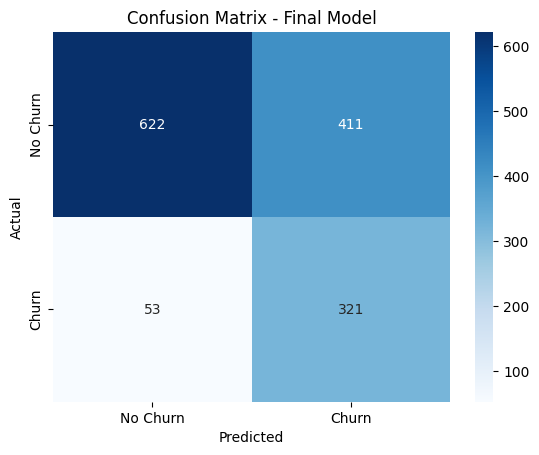

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["No Churn","Churn"],
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Model")
plt.show()

- `Recall Churn (TPR) = 321 / (321+53) = 85.8%` -> Model mampu mendeteksi sebagian besar pelanggan yang benar-benar churn => risiko kehilangan pelanggan bisa diidentifikasi
- `Precision Churn = 321 / (321+411) = 43.8%` => Banyak false alarm -> marketing bisa jadi membuang resource ke pelanggan yang sebenarnya tidak churn.
- `Accuracy = (622+321) / 1407 = 67.1%` -> data imbalance jadi tidak perlu diperhatikan
- `F1-Score Churn = 2 * (Prec * Rec) / (Prec+Rec) ≈ 0.58` -> Balance antara precision & recall masih sedang.

## 📌 Insight:

- `Model ini efektif` menangkap sebagian besar pelanggan yang akan churn -> bagus karena user yang berpotensi churn bisa “diselamatkan” lewat campaign retention.
- Precision churn rendah (44%) -> `banyak false positive` (model mengira pelanggan akan churn, padahal tidak) => biaya campaign bisa lebih tinggi karena banyak pelanggan “sehat” yang ikut kena target.

# Tarik insight: faktor apa yang paling berpengaruh terhadap churn

## Feature Importance

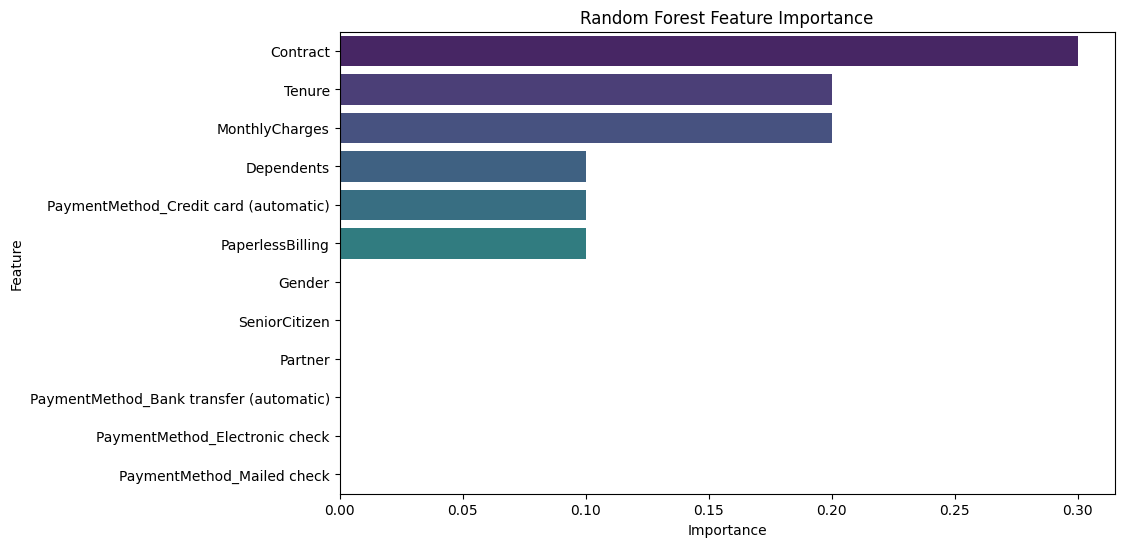

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil feature importance dari model final (rf_best = model hasil tuning)
importances = rf_best_estimator.feature_importances_

# Buat dataframe biar rapi
feat_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importances, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.show()

### 📌 Insight:
- `Contrct (±30%)` -> faktor yang paling dominan => faktor paling kuat memengaruhi kemungkinan churn
- `Tenure dan MonthlyCharges (±20%)` -> penting di posisi kedua => pelanggan baru dengan biaya tinggi cenderung lebih rentan churn
- `Dependents, Payment Method (Credit card), PaperlessBilling (±10%) -> pengaruh moderat pada kemungkinan Churn
- Faktor lain tidak berpengaruh atau sangat kecil (tidak terlihat)

## Permutation Importance

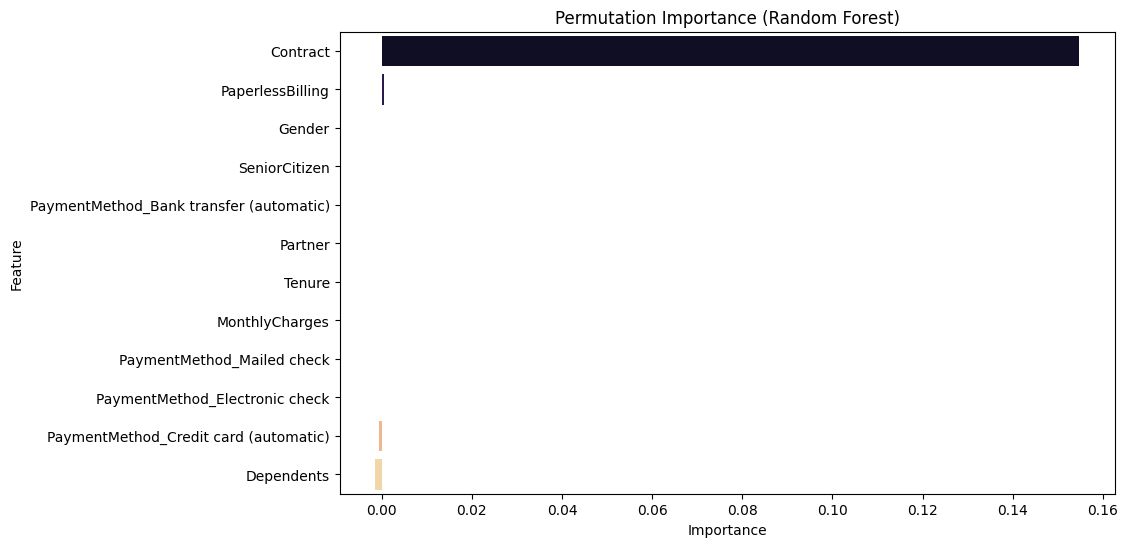

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_best_estimator, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_importances = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=perm_importances, palette="magma")
plt.title("Permutation Importance (Random Forest)")
plt.show()


### 📌 Insight:
- Contract mendominasi jauh dibanding faktor lain -> menegaskan bahwa jenis kontrak adalah penentu utama churn